# Process Tomography
Process tomography allows for the characterisation of a quantum process $\mathcal{E}$, where $\mathcal{E}(\rho) = \rho^\prime$. This is very useful when assessing the exact operation of different quantum gates and can be used for the assessment of gate fidelities.

This notebook demonstates the utilisation of the different process tomography algorithms included within Lightworks. In each the choi matrix is found and used as a characterisation of the quantum process which occured.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lightworks as lw
from lightworks import emulator, qubit
from lightworks.tomography import (
    LIProcessTomography,
    MLEProcessTomography,
    choi_from_unitary,
)

Before starting, a general function is defined to quickly perform the plotting of choi matrices. This takes a complex matrix and plots the real and imaginary parts separately.

In [2]:
def plot_choi_matrix(choi: np.ndarray) -> tuple:
    """
    General function for plotting a choi matrix. It will split up and plot
    the real and imaginary components using a common colorbar between them.
    """
    # Create required plotting data
    xx, yy = np.meshgrid(range(choi.shape[0]), range(choi.shape[1]))
    x, y = xx.ravel(), yy.ravel()
    width = depth = 0.7
    h1 = np.real(choi).flatten()
    h2 = np.imag(choi).flatten()
    base = np.zeros_like(h1)

    # Create figure
    fig = plt.figure(figsize=(11, 5))
    ax1 = fig.add_subplot(121, projection="3d")
    ax2 = fig.add_subplot(122, projection="3d")

    # Plot bar charts
    ax1.bar3d(x, y, base, width, depth, h1, shade=True)
    ax1.set_title("Re(C)")
    ax2.bar3d(x, y, base, width, depth, h2, shade=True)
    ax2.set_title("Im(C)")
    for ax in [ax1, ax2]:
        ax.set_zlim(-1, 1)

    return fig, (ax1, ax2)

## Setup
To perform process tomography, two things are required:
1) The experiment function. This needs to accept a list of circuit and a list of inputs, a list of corresponding results should then be returned. These results can either be the results objects returned within the emulator, or just dictionaries containing states and the corresponding photon counts.
2) The circuit which is being analysed. This should be a Lightworks circuit object, where the number of available modes (excluding heralded) is equal to the number of qubits.

These are both configured below.

In [3]:
def experiment(circuits: list[lw.Circuit], inputs: list[lw.State]) -> list:
    """
    Experiment function which is required for performing state tomography on a
    system. It takes a list of circuits and generates a corresponding list of
    results for each of them. Only supports one qubit systems currently.
    """
    # Post-select on 1 photon across each pair of qubit modes
    post_select = lw.PostSelection()
    post_select.add((0, 1), 1)
    post_select.add((2, 3), 1)

    backend = emulator.Backend("slos")

    # Generate results and return
    results = []
    for circ, in_s in zip(circuits, inputs):
        sampler = lw.Sampler(
            circ, in_s, 10000, post_selection=post_select, random_seed=98
        )
        results.append(backend.run(sampler))
    return results

In this case, we'll examine the post-selected CNOT gate, which acts across two qubits.

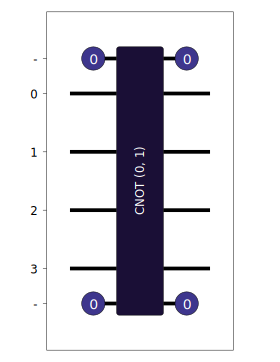

In [4]:
n_qubits = 2

cnot = qubit.CNOT()
cnot.display()

There is then a choice of algorithms that can be used for the calculation of the choi matrix for the process:
1) Linear inversion - this is a simpler algorithm, but can produce non-physical process matrices (particularily in noisy scenarios).
2) Maximum likelihood estimation - this uses a gradient-descent based optimisation, along with a set of projections to enforce conditions for a physical process matrix.

## Linear Inversion
This method is achieved with the LIProcessTomography object. To initialise this, the number of qubits, circuit & experiment function are provided. The choi matrix can then be calculated using the process method.

In [5]:
li_tomo = LIProcessTomography(n_qubits, cnot, experiment)

choi = li_tomo.process()

Once calculated, we plot this to view the structure of the density matrix.

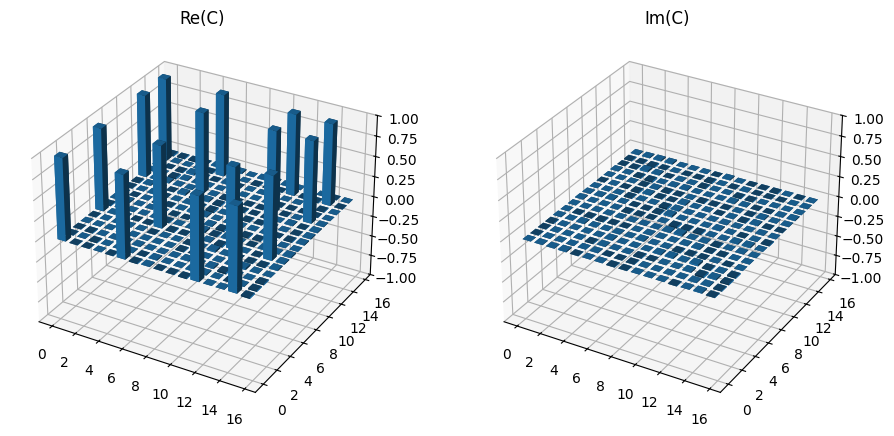

In [6]:
plot_choi_matrix(choi)
plt.show()

The choi_from_untiary function can then be used to find the expected unitary for a CNOT gate and the fidelity calculate with the relevant fidelity method. As expected this is new to 100%>

In [7]:
choi_exp = choi_from_unitary(
    [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]
)
print(f"Fidelity = {round(li_tomo.fidelity(choi_exp) * 100, 4)} %")

Fidelity = 100.2123 %


## Maximum Likelihood Estimation
The pgdB algorithm from <cite data-cite="Knee_2018">(Knee_2018)</cite> is used for the projection and fitting of the choi matrix through maximum likelihood estimation.

This method is implemented using the MLEProcessTomography object and utilised in the same way as above.

In [8]:
mle_tomo = MLEProcessTomography(n_qubits, cnot, experiment)

choi = mle_tomo.process()

Again, the fidelity can be calculated using the expected matrix and the results plotted to confirm the structure remains consistent.

Fidelity = 100.0018 %


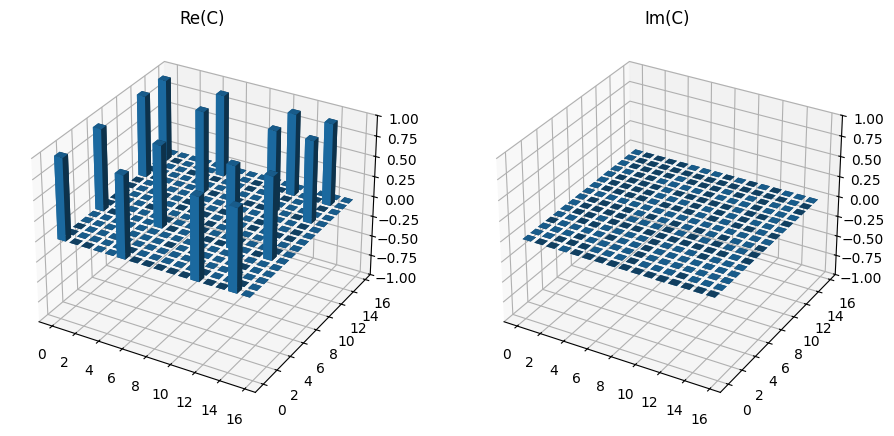

In [9]:
print(f"Fidelity = {round(mle_tomo.fidelity(choi_exp) * 100, 4)} %")

plot_choi_matrix(choi)
plt.show()

### Imperfect Experiment
As with state tomography, it is also possible to introduce imperfections into the experimental simlation, for a better understanding of how these errors affect fidelity.

Again, we'll use a class to create a parameterised experiment with optional single photon source noise.

In [10]:
class SamplerExperiment:
    """
    Runs experiment using the emulator Sampler for a given n_qubits with an
    optional imperfect single photon source.
    """

    def __init__(
        self, n_qubits: int, source: emulator.Source | None = None
    ) -> None:
        self.n_qubits = n_qubits
        self.source = source
        self.n_samples = 25000
        self.random_seed = 123
        self.backend = emulator.Backend("slos")

    def experiment(
        self, circuits: list[lw.Circuit], inputs: list[lw.State]
    ) -> list:
        """
        Generalised version of experiment function above, designed for any
        number of qubits. It is assumes the provided circuits contain dual-rail
        encoded qubits across pairs of adjacent modes.
        """
        # Post-select on 1 photon across each pair of qubit modes
        post_select = lw.PostSelection()
        for i in range(self.n_qubits):
            post_select.add((2 * i, 2 * i + 1), 1)

        # Generate results and return
        results = []
        for circ, in_s in zip(circuits, inputs):
            sampler = lw.Sampler(
                circ,
                in_s,
                self.n_samples,
                source=self.source,
                post_selection=post_select,
                random_seed=self.random_seed,
            )
            results.append(self.backend.run(sampler))
        return results

The single photon source parameters are then configured and assigned below, setting the source indistinguishability to 95% and purity to 99%.

In [11]:
source = emulator.Source(indistinguishability=0.95, purity=0.99)

imperfect_exp = SamplerExperiment(2, source=source)

Once the tomography is performed, as expected we see a drop in fidelity and the presence of additional erroneous elements in the choi matrix.

Fidelity = 85.9243 %


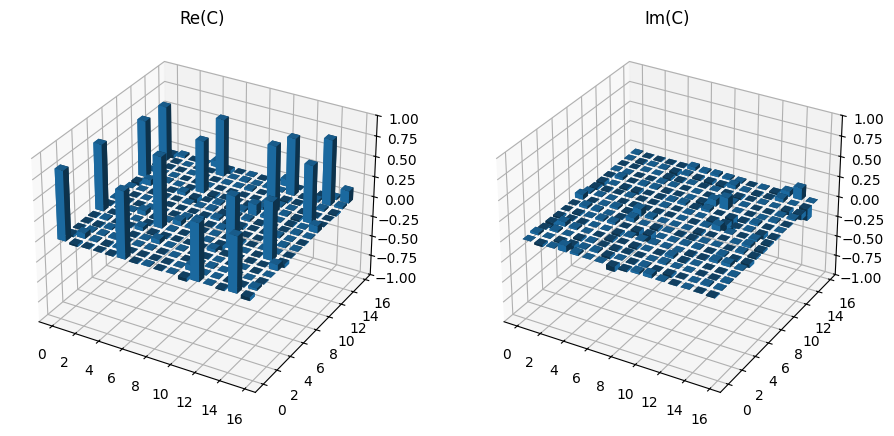

In [12]:
mle_tomo_2 = MLEProcessTomography(n_qubits, cnot, imperfect_exp.experiment)

choi = mle_tomo_2.process()

print(f"Fidelity = {round(mle_tomo_2.fidelity(choi_exp) * 100, 4)} %")

plot_choi_matrix(choi)
plt.show()